# Version II - dynamic data augmentation

### Imports and initial setup

In [2]:
import import_ipynb

#pip install tensorflow-addons
import tensorflow_addons as tfa

from InitialSetup import dataset, BATCH_SIZE, tf, prepare_callbacks, model_VI, show_history, test_dataset

importing Jupyter notebook from InitialSetup.ipynb
Num GPUs Available:  1
Total images in validatation dataset:  12630
(32, 32, 3) (43,)
Total images in dataset:  39209


### Functions to transform image

In [2]:
def process_image_trans(image, label):
    
    rx = tf.random.uniform(shape=(), minval=0, maxval=20) - 10
    ry = tf.random.uniform(shape=(), minval=0, maxval=8) - 4
    image = tfa.image.translate(image, [rx, ry])

    return image, label

def process_image_rot(image, label):
    
    r = tf.random.uniform(shape=(), minval=0, maxval=0.5, dtype=tf.dtypes.float32) - 0.25
    image = tfa.image.rotate(image, r)
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 0.4, 1.1, 0.4, 1.1), 0.0, 1.0)

    #image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=0.1)-0.2),0,1)
    return image, label


### Preparation of the training and validation dataset

In [3]:

dataSoloV2 = dataset.map(process_image_trans)
dataSoloV2 = dataSoloV2.concatenate(dataset.map(process_image_rot))
dataSoloV2_size = tf.data.experimental.cardinality(dataSoloV2).numpy()

dataSoloV2 = dataSoloV2.cache()
dataSoloV2 = dataSoloV2.shuffle(buffer_size = dataSoloV2_size)
dataSoloV2 = dataSoloV2.prefetch(buffer_size = dataSoloV2_size)
dataSoloV2 = dataSoloV2.batch(batch_size = BATCH_SIZE)
dataSoloV2 = dataSoloV2.repeat()

train_size = int(0.8* dataSoloV2_size)
val_size = int(0.2* dataSoloV2_size)

train_dataset = dataSoloV2.take(train_size)
val_dataset = dataSoloV2.skip(train_size)


### Setup model and save place

In [3]:
modelV2 = model_VI(43, 32, 3)

file_pathV2 = './Networks/SmallDataAugmentation.ckpt'

callbacksV2 = prepare_callbacks(file_pathV2)

### Train model

In [4]:
historyV2 = modelV2.fit(train_dataset, steps_per_epoch = train_size/BATCH_SIZE,
          epochs=20, 
          validation_data = val_dataset,
          validation_steps = val_size/BATCH_SIZE,
          callbacks = callbacksV2)

Epoch 1/20
980/980 [==============================] - 49s 30ms/step - loss: 3.5332 - accuracy: 0.1327 - val_loss: 1.6504 - val_accuracy: 0.5300

Epoch 00001: val_accuracy improved from -inf to 0.52998, saving model to ./Networks\SmallDataAugmentation.ckpt
Epoch 2/20
980/980 [==============================] - 29s 30ms/step - loss: 1.8470 - accuracy: 0.4686 - val_loss: 0.7901 - val_accuracy: 0.7600

Epoch 00002: val_accuracy improved from 0.52998 to 0.75997, saving model to ./Networks\SmallDataAugmentation.ckpt
Epoch 3/20
980/980 [==============================] - 29s 30ms/step - loss: 1.1241 - accuracy: 0.6574 - val_loss: 0.4714 - val_accuracy: 0.8589

Epoch 00003: val_accuracy improved from 0.75997 to 0.85893, saving model to ./Networks\SmallDataAugmentation.ckpt
Epoch 4/20
980/980 [==============================] - 29s 30ms/step - loss: 0.7375 - accuracy: 0.7684 - val_loss: 0.2801 - val_accuracy: 0.9182

Epoch 00004: val_accuracy improved from 0.85893 to 0.91819, saving model to ./Net

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


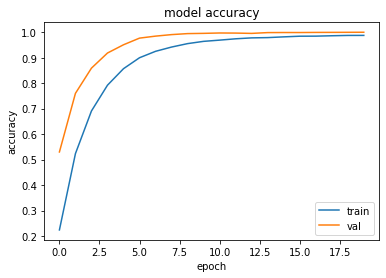

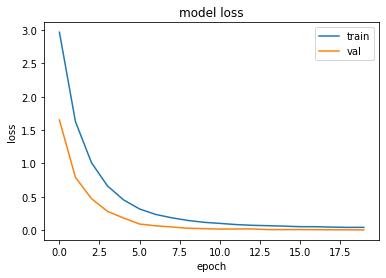

198/198 - 2s - loss: 0.0612 - accuracy: 0.9829
245/245 - 10s - loss: 0.0020 - accuracy: 0.9996


In [6]:
show_history(historyV2)

modelV2.load_weights(file_pathV2)

evalV2 = modelV2.evaluate(test_dataset, verbose=2)
valV2 = modelV2.evaluate(val_dataset, steps=val_size/BATCH_SIZE, verbose=2)